# Data Wrangling - Olympics Success Factors Project
- Antón Fidalgo Pérez
- Peter Samuelsen Gabriel
- Samuel Heras de Paz

## What factors influence a country's representation in the Olympics from 1896 to 2016? 

We first will the library **pandas** and will read the file that contains the data set.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

In [5]:
# open file
file = 'athlete_events.csv'
regions = 'noc_regions.csv'
temperatures = 'city_temperature.csv'

df = pd.read_csv(file)
noc_regions = pd.read_csv(regions)
temp = pd.read_csv(temperatures, low_memory=False)

Have a look at our data set, the different rows and columns.

In [7]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [8]:
noc_regions.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [9]:
temp.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


## 1. Geographical, Climate and Economic Factors
### 1.1. Does hosting the Olympics increase a country's athlete representation?

To have a good answer to this question, we will focus our work towards the countries that have hosted the olympics the most times. Remeber that the data set we are working with has data from Athens 1896 to Rio 2016. Since we only have data about hosting city and not hosting country, we will create a mapping city to country first.

In [12]:
city_to_country = {
    'Barcelona': 'Spain',
    'London': 'United Kingdom',
    'Beijing': 'China',
    'Sydney': 'Australia',
    'Athens': 'Greece',
    'Rio de Janeiro': 'Brazil',
    'Tokyo': 'Japan',
    'Los Angeles': 'United States',
    'Paris': 'France',
    'Antwerpen': 'Belgium',
    'Calgary': 'Canada',
    'Albertville': 'France',
    'Lillehammer': 'Norway',
    'Salt Lake City': 'United States',
    'Helsinki': 'Finland',
    'Lake Placid': 'United States',
    'Atlanta': 'United States',
    'Stockholm': 'Sweden',
    'Sochi': 'Russia',
    'Nagano': 'Japan',
    'Torino': 'Italy',
    'Squaw Valley': 'United States',
    'Innsbruck': 'Austria',
    'Sarajevo': 'Bosnia and Herzegovina',
    'Mexico City': 'Mexico',
    'Munich': 'Germany',
    'Seoul': 'South Korea',
    'Berlin': 'Germany',
    'Oslo': 'Norway',
    "Cortina d'Ampezzo": 'Italy',
    'Melbourne': 'Australia',
    'Roma': 'Italy',
    'Amsterdam': 'Netherlands',
    'Montreal': 'Canada',
    'Moskva': 'Russia',
    'Vancouver': 'Canada',
    'Grenoble': 'France',
    'Sapporo': 'Japan',
    'Chamonix': 'France',
    'St. Louis': 'United States',
    'Sankt Moritz': 'Switzerland',
    'Garmisch-Partenkirchen': 'Germany'
}

Then, we can find a list of countries that have hosted the olympics more than two times.

In [14]:
summer_olympics = df[df['Season'] == 'Summer'].copy()
summer_olympics['Country'] = summer_olympics['City'].map(city_to_country)
unique_games_by_country = summer_olympics[['Country', 'Games']].drop_duplicates()
hosted_olympics = unique_games_by_country.groupby('Country')['Games'].agg(['count', list]).reset_index()
countries_list = hosted_olympics[hosted_olympics['count'] > 2]
countries_list.columns = ['Country', 'Total Hosted', 'Games Hosted']
print(countries_list)


           Country  Total Hosted  \
16  United Kingdom             3   
17   United States             4   

                                         Games Hosted  
16            [2012 Summer, 1948 Summer, 1908 Summer]  
17  [1932 Summer, 1996 Summer, 1984 Summer, 1904 S...  


As we can see, only the United Stated and the United Kingdom have hosted more than two times the Olympics within the time frame, four and three times respectively. For the United Kinkgdom, that was 2012, 1948 and 1908; for the United States, that was 1932, 1996, 1984 and 1904. Hence, we are going to focus on those two countries. We will sum up the number of athletes the UK and US sent to each Olympics in the past. We can visualize it easily with a bar plot. 

Notice that we will not use the column **Team** since it is unconsistent, we will need to merge with data set **noc_regions** to know the actual countries the athletes play for.

In [17]:
noc_data = pd.merge(df, noc_regions, on='NOC', how='left')

us_uk_data = noc_data[noc_data['NOC'].isin(['USA', 'GBR'])]
number_athletes = (us_uk_data.groupby(['Year', 'NOC'])['ID'].nunique()
                  .reset_index()
                  .rename(columns={'ID': 'Total Athletes'}))

Now, visualise it in the plot, only focusing in the olympic years, which are they years we have data from.

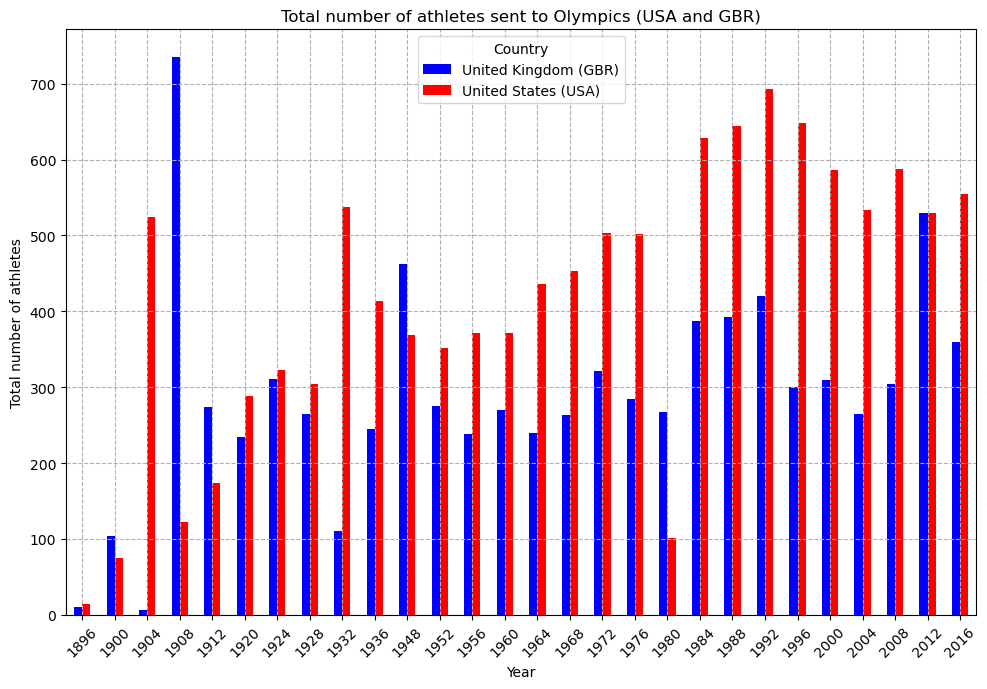

In [19]:
olympic_years = number_athletes['Year'].unique()
olympic_years = sorted(year for year in olympic_years if year % 4 == 0)

number_athletes_pivot = (number_athletes.pivot(index='Year', columns='NOC', values='Total Athletes').reindex(olympic_years))


plt.figure(figsize=(10, 7))
number_athletes_pivot.plot(kind='bar', stacked=False, ax=plt.gca(), color=['blue', 'red'])
plt.title('Total number of athletes sent to Olympics (USA and GBR)')
plt.xlabel('Year')
plt.ylabel('Total number of athletes')
plt.legend(title='Country', labels=['United Kingdom (GBR)', 'United States (USA)'])
plt.grid(True, linestyle='--')
plt.xticks(ticks=range(len(olympic_years)), labels=olympic_years, rotation=45) 
plt.tight_layout()
plt.show()


Notice how we can find peaks of the total number of athletes sent by the hosting countries, for both the UK and the US.

Also, we will add a control country to have a better prespective on the topic. We have chosen Hungary, a country who does usually fairly good (for the 2024 Olympics ranked 14 in medal winning) but that has never hosted the Games.

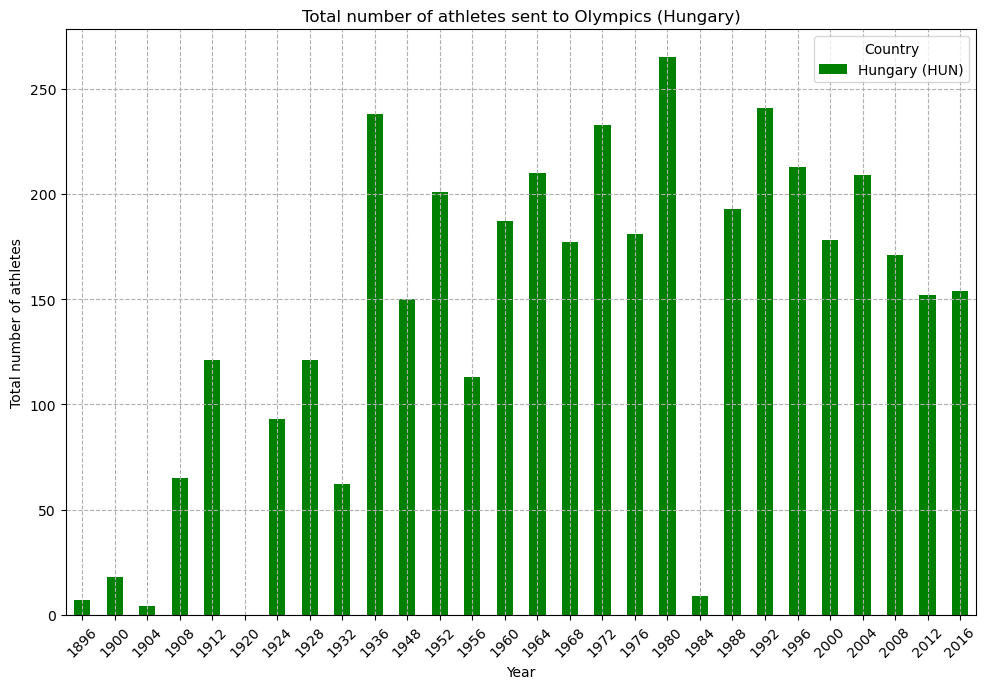

In [22]:
hungary_data = noc_data[noc_data['NOC'] == 'HUN']

hungary_number_athletes = (hungary_data.groupby(['Year', 'NOC'])['ID']
                        .nunique()
                        .reset_index()
                        .rename(columns={'ID': 'Total Athletes'}))

hungary_number_athletes_pivot = hungary_number_athletes.pivot(index='Year', columns='NOC', values='Total Athletes')
hungary_number_athletes_pivot = hungary_number_athletes_pivot.reindex(olympic_years)

plt.figure(figsize=(10, 7))
hungary_number_athletes_pivot.plot(kind='bar', stacked=False, ax=plt.gca(), color='green')
plt.title('Total number of athletes sent to Olympics (Hungary)')
plt.xlabel('Year')
plt.ylabel('Total number of athletes')
plt.legend(title='Country', labels=['Hungary (HUN)'])
plt.grid(True, linestyle='--')
plt.xticks(ticks=range(len(olympic_years)), labels=olympic_years, rotation=45) 
plt.tight_layout()
plt.show()


The case of Hungary confirms the case that the years that the UK or US hosted, the hosting country did indeed send more athletes but that for third countries this was not relevant. Hence, there is a clear trend: the hosting country of the Olympic Games is more represented than when not hosting.

Going deeper into Hungary's case, we realised a courious coincidence. The year that Hungary sent the most athletes to the Olympic Games, when it peaked, was the year 1980. Indagating a bit, we realise that year the Olympics were held in the already dissolved Soviet Union, specifically its capital Moscow. Also, the year 1980 was election year in Hungary, which was won by the Patriotic People's Font originally funded by the Hungarian Communist Party. All of this leads us to think that that might be the reason which why Hungary sent so many athletes in 1980, reinforcing our point. 

Notice as well the year 1984. From the result previously, we learnt that the Olympics that year were held in the USA. More specifically Los Angeles. With a bit of research we know that that Hungary was part of the 1984 summer olympics boycott. Hungary decided not to attend together with 15 other countries of the Eastern bloc led by the Soviet Union. 

President Carter's 1984 summer olympics boycot occured as a response to the 1980 summer olympic boycott. That year, as explained previously, the Olympics where held in Moscow. As a repriment to the Soviet Union invasion of Afghanistan, United States and many countries boycotted the games and decided not to attend.

We can notice as well the strong participation of the US and UK in the Olympic years in the 80's and early 90's. After the analysis done, we can assume that the Olympics need to be observed in the context of the cold war. Both parties were also fighting indirectly in the Olympics.

### 1.2. Does having a similar climate to the host country have any significant impact on representation in outdoor sports?

After having a quick look on the average temperature data set the first thing we notice is that it needs to be clean, since it has non-sense values like -99 degrees Farenheit. We will also need to convert the data from Farenheit to Celsius, for easier usage and understandability.

#### 1.2.1 Summer Olympics

##### 1.2.1.1 Outdoor sports

In [32]:
temp = temp[temp['AvgTemperature'] != -99]
temp['AvgTemperature'] = (temp['AvgTemperature'] - 32) * 5.0 / 9.0
temp.rename(columns={'AvgTemperature': 'Avg_Temperature_Celsius'}, inplace=True)

In [33]:
temp.head()

,Region,Country,State,City,Month,Day,Year,Avg_Temperature_Celsius
0,Africa,Algeria,NaN,Algiers,1,1,1995,17.888889
1,Africa,Algeria,NaN,Algiers,1,2,1995,9.666667
2,Africa,Algeria,NaN,Algiers,1,3,1995,9.333333
3,Africa,Algeria,NaN,Algiers,1,4,1995,8.000000
4,Africa,Algeria,NaN,Algiers,1,5,1995,8.833333


We will first to an analysis of how temperature has an impact on representation in outdoor olympics sports, only regarding the summer olympics. Because of this, we will only foucus on the summer months, that is June, July and August. With that, we can calculate the average summer temperature of each country between 1995 and 2020, the data provided by the dataset. We group the data by country since it comes detailed by city. Then we calculate the mean, that comes for each deay. 

We decided to look at the data overall and not per year for various reasons. One of them being the very slight difference of temperature between the different years in the same pleace. Because of that, we can use the data also for other all the years of the athlete data set, that does from 1896 too 2016.

In [35]:
summer_months = [6, 7, 8]
summer_temp = temp[temp['Month'].isin(summer_months)]

avg_summer_temp = (summer_temp.groupby('Country')['Avg_Temperature_Celsius']
                              .mean()
                              .reset_index())

In [36]:
avg_summer_temp.head()

,Country,Avg_Temperature_Celsius
0,Albania,24.986741
1,Algeria,25.059699
2,Argentina,11.075293
3,Australia,11.753586
4,Austria,20.450424


Similarly as done before, we need to know the country of the hosting city more than the country in order to merge with the data of the average summer temperature by year. Hence, we will do a mapping city to country and add it as a new column.

In [38]:
def assign_country(city):
    return city_to_country.get(city, 'Unknown')

df['Host_Country'] = df['City'].apply(assign_country)

In [39]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Host_Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,Spain
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Belgium
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada


Again, just how a map was needed to know which city belongs to what country, a map to know if a sport is played outdors or indoors is needed. The following dictionary contains the description of all the 66 unique sports played at the Olympics over the 120 years.

In [41]:
indoor_or_outdoor = {
'Aeronautics': 'Outdoor',
'Alpine Skiing': 'Outdoor',
'Alpinism': 'Outdoor',
'Archery': 'Outdoor',
'Art Competitions': 'Indoor',
'Athletics': 'Outdoor',
'Badminton': 'Indoor',
'Baseball': 'Outdoor',
'Basketball': 'Indoor',
'Basque Pelota': 'Indoor',
'Beach Volleyball': 'Outdoor',
'Biathlon': 'Outdoor',
'Bobsleigh': 'Outdoor',
'Boxing': 'Indoor',
'Canoeing': 'Outdoor',
'Cricket': 'Outdoor',
'Croquet': 'Outdoor',
'Cross Country Skiing': 'Outdoor',
'Curling': 'Indoor',
'Cycling': 'Outdoor',
'Diving': 'Indoor',
'Equestrianism': 'Outdoor',
'Fencing': 'Indoor',
'Figure Skating': 'Indoor',
'Football': 'Outdoor',
'Freestyle Skiing': 'Outdoor',
'Golf': 'Outdoor',
'Gymnastics': 'Indoor',
'Handball': 'Indoor',
'Hockey': 'Outdoor',
'Ice Hockey': 'Indoor',
'Jeu De Paume': 'Indoor',
'Judo': 'Indoor',
'Lacrosse': 'Outdoor',
'Luge': 'Outdoor',
'Military Ski Patrol': 'Outdoor',
'Modern Pentathlon': 'Outdoor',
'Motorboating': 'Outdoor',
'Nordic Combined': 'Outdoor',
'Polo': 'Outdoor',
'Racquets': 'Indoor',
'Rhythmic Gymnastics': 'Indoor',
'Roque': 'Outdoor',
'Rowing': 'Outdoor',
'Rugby': 'Outdoor',
'Rugby Sevens': 'Outdoor',
'Sailing': 'Outdoor',
'Shooting': 'Outdoor',
'Short Track Speed Skating': 'Indoor',
'Skeleton': 'Outdoor',
'Ski Jumping': 'Outdoor',
'Snowboarding': 'Outdoor',
'Softball': 'Outdoor',
'Speed Skating': 'Indoor',
'Swimming': 'Indoor',
'Synchronized Swimming': 'Indoor',
'Table Tennis': 'Indoor',
'Taekwondo': 'Indoor',
'Tennis': 'Outdoor',
'Trampolining': 'Indoor',
'Triathlon': 'Outdoor',
'Tug-Of-War': 'Outdoor',
'Volleyball': 'Indoor',
'Water Polo': 'Indoor',
'Weightlifting': 'Indoor',
'Wrestling': 'Indoor'
}

df['Type'] = df['Sport'].map(indoor_or_outdoor)

In [42]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Host_Country,Type
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,Spain,Indoor
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom,Indoor
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Belgium,Outdoor
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France,Outdoor
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada,Indoor


With all the information needed in the columns, we first will create a new column containing the host country average summer temperature. We make sure that we do not include any data for winter olympics nor indoor sports by adding in those the value **NaN**.

In [44]:
country_avg_temp = avg_summer_temp.groupby('Country')['Avg_Temperature_Celsius'].mean().to_dict()
df['Host_Country_Temp'] = df['Host_Country'].map(country_avg_temp)
df.loc[(df['Season'] != 'Summer') | (df['Type'] == 'Indoor'), 'Host_Country_Temp'] = None


In [45]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Host_Country,Type,Host_Country_Temp
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,Spain,Indoor,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom,Indoor,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Belgium,Outdoor,17.770467
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France,Outdoor,20.172595
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada,Indoor,NaN


In order to create the column of the average summer temperature of the home country of the atlete we need to know the country they come from. Since the column **Team** variates and has many exceptions, we will work with the **NOC** column. As done previously, we will do a mapping between NOC and country using the **noc_regions** data set.

In [47]:
df['Origin_Country'] = df['NOC'].map(noc_regions.set_index('NOC')['region'])

After that, we can create a column with the average summer temperature of the origin country of the athlete. This is done just like before, still keeping in mind that it needs to be a sport within the summer olympics and an outdoor sport.

In [49]:
df['Origin_Country_Temp'] = df['Origin_Country'].map(country_avg_temp)
df.loc[(df['Season'] != 'Summer') | (df['Type'] == 'Indoor'), 'Origin_Country_Temp'] = None

In [50]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Host_Country,Type,Host_Country_Temp,Origin_Country,Origin_Country_Temp
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,Spain,Indoor,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom,Indoor,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Belgium,Outdoor,17.770467,Denmark,16.349431
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France,Outdoor,20.172595,Denmark,16.349431
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada,Indoor,NaN,Netherlands,NaN


We calculate the difference of the host country average temperature and the athlete's origin country by simply substracting the both columns of the dataset.

In [52]:
df['Temp_Difference'] = df['Host_Country_Temp'] - df['Origin_Country_Temp']

In [53]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,City,Sport,Event,Medal,Host_Country,Type,Host_Country_Temp,Origin_Country,Origin_Country_Temp,Temp_Difference
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Barcelona,Basketball,Basketball Men's Basketball,NaN,Spain,Indoor,NaN,China,NaN,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,London,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom,Indoor,NaN,China,NaN,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Antwerpen,Football,Football Men's Football,NaN,Belgium,Outdoor,17.770467,Denmark,16.349431,1.421036
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France,Outdoor,20.172595,Denmark,16.349431,3.823164
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada,Indoor,NaN,Netherlands,NaN,NaN


Once the differences are achieved, we need to categorize them. As seen, in the next cell, we will create for categories depending on how big the difference of the temperatures is, from significantly warmer (more than ten degrees more), to warmer (between 5 and 10 degrees more), to similar (between 5 less and 5 degrees more), to colder (between 10 degrees less and 5 degrees less), to significantly colder (more than 10 degrees less). An additional column with the correspondent categories will be created.

In [55]:
def temp_diff_levels(difference):
    if pd.isna(difference):  
        return np.nan
    elif difference >= 10:
        return 'Significantly Warmer'
    elif 5 <= difference < 10:
        return 'Warmer'
    elif -5 < difference < 5:
        return 'Similar'
    elif -10 <= difference <= -5:
        return 'Colder'
    else:
        return 'Significantly Colder'

df['TemperatureDifferenceLevels'] = df['Temp_Difference'].apply(temp_diff_levels)

In [56]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,Host_Country,Type,Host_Country_Temp,Origin_Country,Origin_Country_Temp,Temp_Difference,TemperatureDifferenceLevels
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,...,Basketball,Basketball Men's Basketball,NaN,Spain,Indoor,NaN,China,NaN,NaN,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,NaN,United Kingdom,Indoor,NaN,China,NaN,NaN,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,...,Football,Football Men's Football,NaN,Belgium,Outdoor,17.770467,Denmark,16.349431,1.421036,Similar
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,...,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,France,Outdoor,20.172595,Denmark,16.349431,3.823164,Similar
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,...,Speed Skating,Speed Skating Women's 500 metres,NaN,Canada,Indoor,NaN,Netherlands,NaN,NaN,NaN


Finally, we will plot the number of athletes belonging to each category of difference of temperature each year.

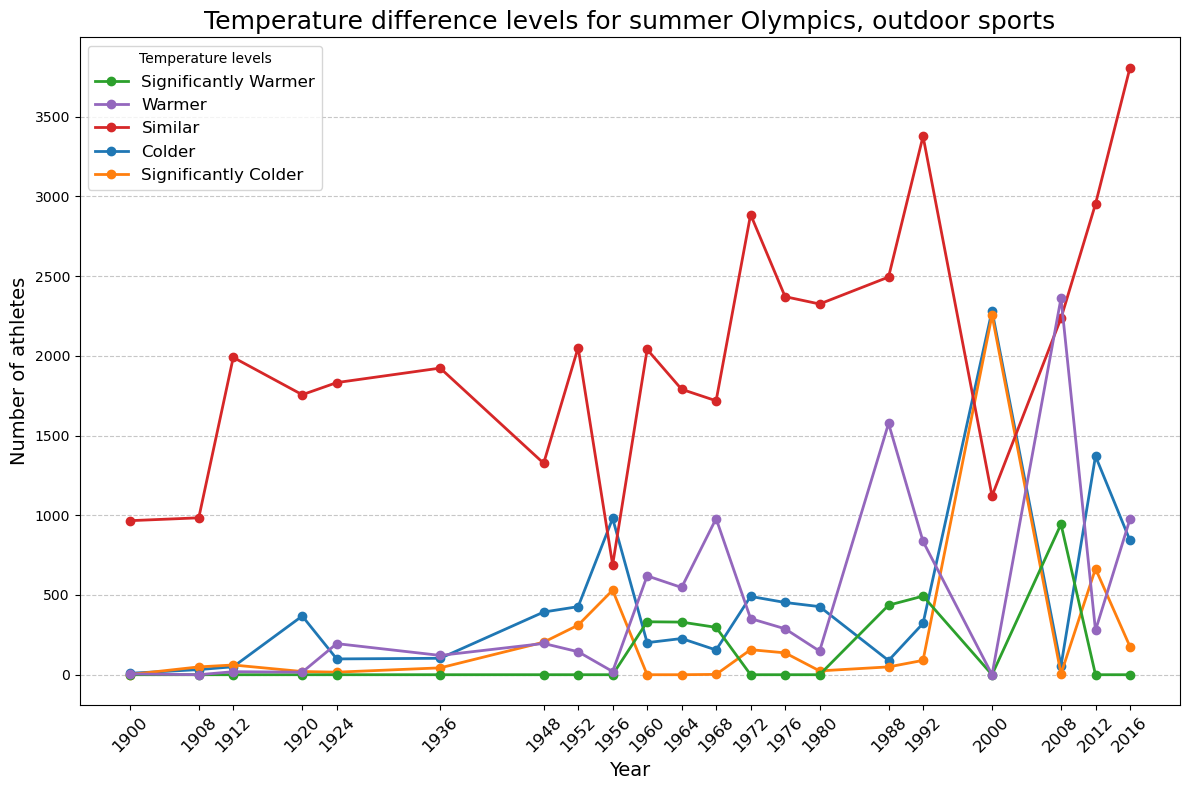

In [58]:
yearly_counts = df.groupby(['Year', 'TemperatureDifferenceLevels']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
for level in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[level], label=level, marker='o', linewidth=2)
plt.title('Temperature difference levels for summer Olympics, outdoor sports', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of athletes', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
new_order = ['Significantly Warmer', 'Warmer', 'Similar', 'Colder', 'Significantly Colder']
ordered_handles = [handles[labels.index(label)] for label in new_order]
plt.legend(ordered_handles, new_order, title='Temperature levels', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_counts.index, rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

We can derive many outcomes from this graph, the main ones are the following:
- Mostly athletes from that share a similar temperature with the host country are sent to the Olympics.
- We notice that there are peaks of higher temperature difference in 1968, 2000 and 2016. The olympics in 1968 were held in October in Mexico, we can disregard it since it is outside summer months. The Olympics of Sydney 2000 and Rio 2016 have in common that both were held in the southern hemisphere. In said hemisphere, the months of June, July and August are considered winter and have much more temperature difference with other northern hemisphere countries. Given that most of the athletes come from countries in the northern hemisphere, that would explain the graph.
- Overall, we can afirm that there is a trend that even countries with a big temperature differents send more athletes now than they did in the past. We can hypothesize that this is due to the improvement of the technologies available in for high performance athletes.

##### 1.2.1.2 Indoor sports

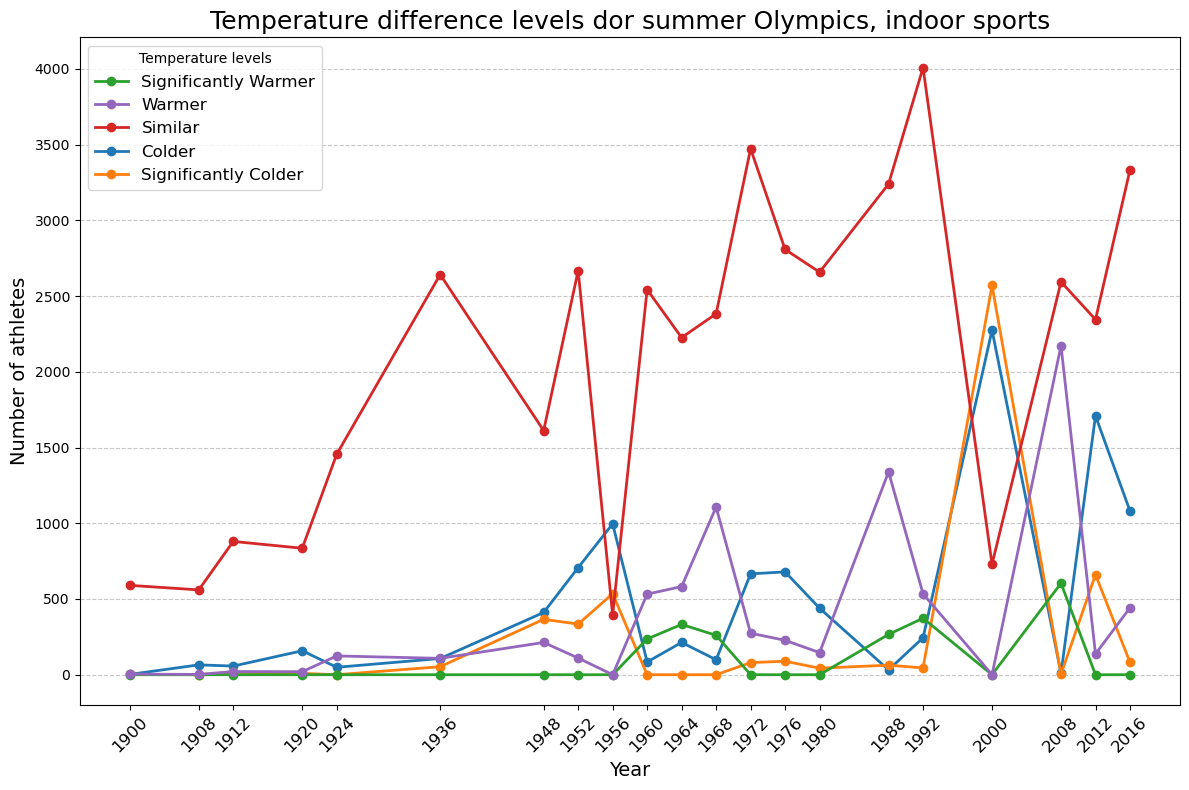

In [61]:
df = pd.read_csv(file)
noc_regions = pd.read_csv(regions)
temp = pd.read_csv(temperatures, low_memory=False)

temp = temp[temp['AvgTemperature'] != -99]
temp['AvgTemperature'] = (temp['AvgTemperature'] - 32) * 5.0 / 9.0
temp.rename(columns={'AvgTemperature': 'Avg_Temperature_Celsius'}, inplace=True)

summer_months = [6, 7, 8]
summer_temp = temp[temp['Month'].isin(summer_months)]

avg_summer_temp = (summer_temp.groupby('Country')['Avg_Temperature_Celsius']
                              .mean()
                              .reset_index())

df['Host_Country'] = df['City'].apply(assign_country)
df['Type'] = df['Sport'].map(indoor_or_outdoor)

country_avg_temp = avg_summer_temp.groupby('Country')['Avg_Temperature_Celsius'].mean().to_dict()
df['Host_Country_Temp'] = df['Host_Country'].map(country_avg_temp)
df.loc[(df['Season'] != 'Summer') | (df['Type'] != 'Indoor'), 'Host_Country_Temp'] = None

df['Origin_Country'] = df['NOC'].map(noc_regions.set_index('NOC')['region'])
df['Origin_Country_Temp'] = df['Origin_Country'].map(country_avg_temp)
df.loc[(df['Season'] != 'Summer') | (df['Type'] != 'Indoor'), 'Origin_Country_Temp'] = None

df['Temp_Difference'] = df['Host_Country_Temp'] - df['Origin_Country_Temp']

df['TemperatureDifferenceLevels'] = df['Temp_Difference'].apply(temp_diff_levels)

yearly_counts = df.groupby(['Year', 'TemperatureDifferenceLevels']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
for level in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[level], label=level, marker='o', linewidth=2)
plt.title('Temperature difference levels dor summer Olympics, indoor sports', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of athletes', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
new_order = ['Significantly Warmer', 'Warmer', 'Similar', 'Colder', 'Significantly Colder']
ordered_handles = [handles[labels.index(label)] for label in new_order]
plt.legend(ordered_handles, new_order, title='Temperature levels', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_counts.index, rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

#### 1.2.2 Winter Olympics
##### 1.2.2.1 Outdoor sports

We will do similarly the for winter Olympics.

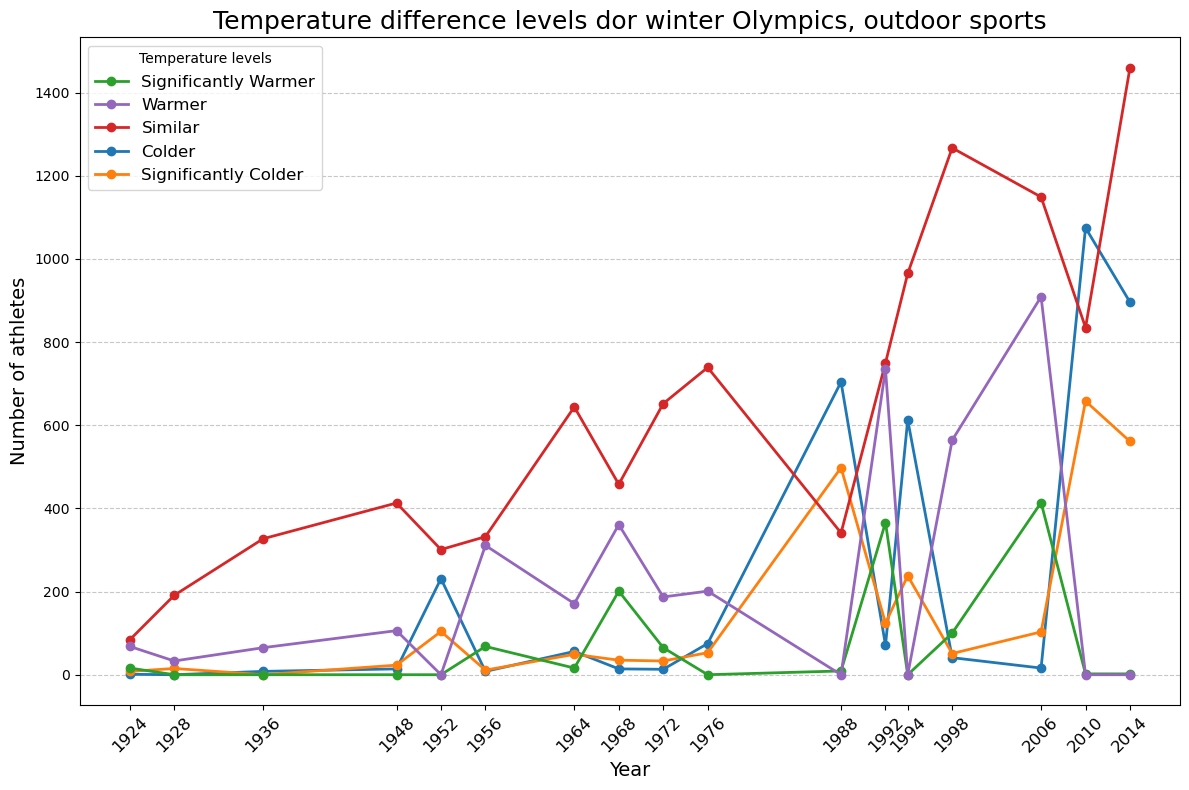

In [64]:
df = pd.read_csv(file)
noc_regions = pd.read_csv(regions)
temp = pd.read_csv(temperatures, low_memory=False)

temp = temp[temp['AvgTemperature'] != -99]
temp['AvgTemperature'] = (temp['AvgTemperature'] - 32) * 5.0 / 9.0
temp.rename(columns={'AvgTemperature': 'Avg_Temperature_Celsius'}, inplace=True)

winter_months = [1, 2, 12]
winter_temp = temp[temp['Month'].isin(winter_months)]

avg_winter_temp = (winter_temp.groupby('Country')['Avg_Temperature_Celsius']
                              .mean()
                              .reset_index())

df['Host_Country'] = df['City'].apply(assign_country)
df['Type'] = df['Sport'].map(indoor_or_outdoor)

country_avg_temp = avg_winter_temp.groupby('Country')['Avg_Temperature_Celsius'].mean().to_dict()
df['Host_Country_Temp'] = df['Host_Country'].map(country_avg_temp)
df.loc[(df['Season'] == 'Summer') | (df['Type'] == 'Indoor'), 'Host_Country_Temp'] = None

df['Origin_Country'] = df['NOC'].map(noc_regions.set_index('NOC')['region'])
df['Origin_Country_Temp'] = df['Origin_Country'].map(country_avg_temp)
df.loc[(df['Season'] == 'Summer') | (df['Type'] == 'Indoor'), 'Origin_Country_Temp'] = None

df['Temp_Difference'] = df['Host_Country_Temp'] - df['Origin_Country_Temp']

df['TemperatureDifferenceLevels'] = df['Temp_Difference'].apply(temp_diff_levels)

yearly_counts = df.groupby(['Year', 'TemperatureDifferenceLevels']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
for level in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[level], label=level, marker='o', linewidth=2)
plt.title('Temperature difference levels dor winter Olympics, outdoor sports', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of athletes', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
new_order = ['Significantly Warmer', 'Warmer', 'Similar', 'Colder', 'Significantly Colder']
ordered_handles = [handles[labels.index(label)] for label in new_order]
plt.legend(ordered_handles, new_order, title='Temperature levels', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_counts.index, rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

##### 1.2.2.1 Indoor sports

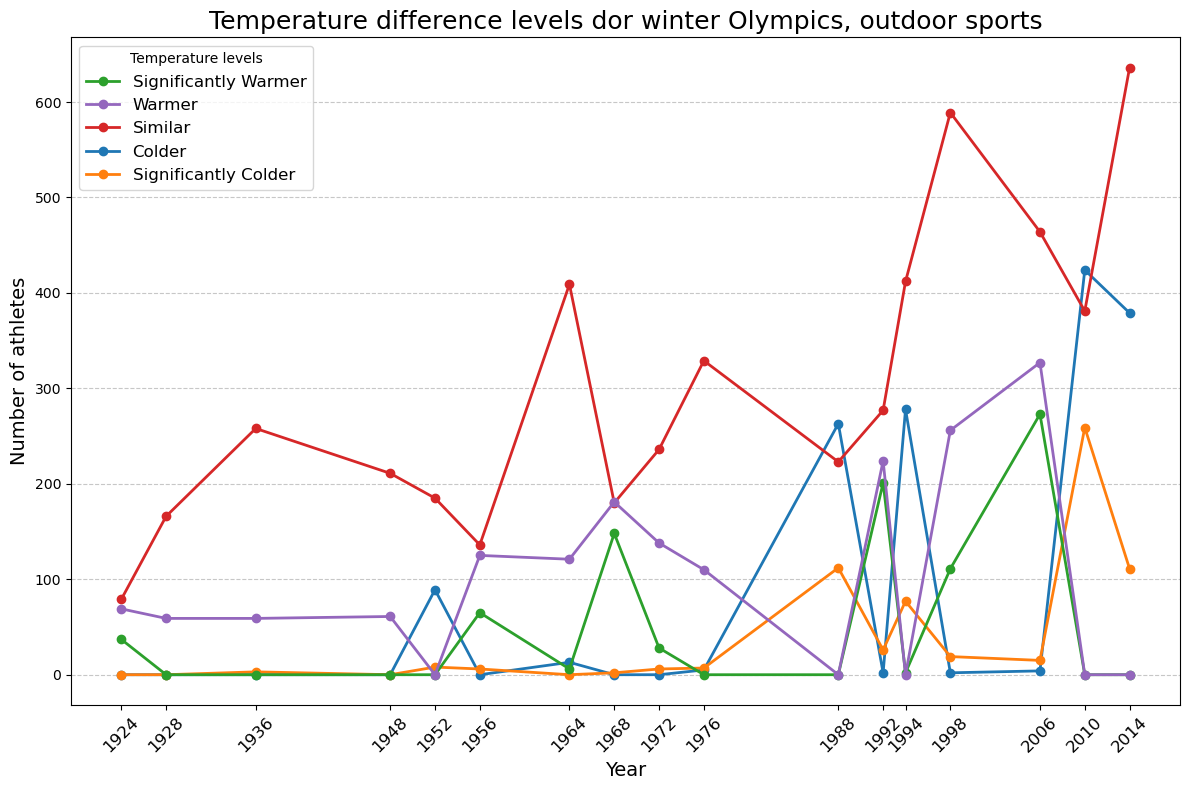

In [66]:
df = pd.read_csv(file)
noc_regions = pd.read_csv(regions)
temp = pd.read_csv(temperatures, low_memory=False)

temp = temp[temp['AvgTemperature'] != -99]
temp['AvgTemperature'] = (temp['AvgTemperature'] - 32) * 5.0 / 9.0
temp.rename(columns={'AvgTemperature': 'Avg_Temperature_Celsius'}, inplace=True)

winter_months = [1, 2, 12]
winter_temp = temp[temp['Month'].isin(winter_months)]

avg_winter_temp = (winter_temp.groupby('Country')['Avg_Temperature_Celsius']
                              .mean()
                              .reset_index())

df['Host_Country'] = df['City'].apply(assign_country)
df['Type'] = df['Sport'].map(indoor_or_outdoor)

country_avg_temp = avg_winter_temp.groupby('Country')['Avg_Temperature_Celsius'].mean().to_dict()
df['Host_Country_Temp'] = df['Host_Country'].map(country_avg_temp)
df.loc[(df['Season'] == 'Summer') | (df['Type'] != 'Indoor'), 'Host_Country_Temp'] = None

df['Origin_Country'] = df['NOC'].map(noc_regions.set_index('NOC')['region'])
df['Origin_Country_Temp'] = df['Origin_Country'].map(country_avg_temp)
df.loc[(df['Season'] == 'Summer') | (df['Type'] != 'Indoor'), 'Origin_Country_Temp'] = None

df['Temp_Difference'] = df['Host_Country_Temp'] - df['Origin_Country_Temp']

df['TemperatureDifferenceLevels'] = df['Temp_Difference'].apply(temp_diff_levels)

yearly_counts = df.groupby(['Year', 'TemperatureDifferenceLevels']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
for level in yearly_counts.columns:
    plt.plot(yearly_counts.index, yearly_counts[level], label=level, marker='o', linewidth=2)
plt.title('Temperature difference levels dor winter Olympics, outdoor sports', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of athletes', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
new_order = ['Significantly Warmer', 'Warmer', 'Similar', 'Colder', 'Significantly Colder']
ordered_handles = [handles[labels.index(label)] for label in new_order]
plt.legend(ordered_handles, new_order, title='Temperature levels', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_counts.index, rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

### 1.3. Does being geographically closer to the host country have any significant impact on athlete representation?

We start by reading the **Athlete Events** CSV file, which contains all the key information about the Olympic Games for this project

In [69]:
data_path = 'athlete_events.csv'
athlete_events = pd.read_csv(data_path)


The following function takes a country name as input and finds its corresponding time zone using the pytz library. It matches the country name to a country code, retrieves the list of time zones for that code, and returns the first time zone in the list. If no match or time zone is found, it defaults to 'UTC'.

In [71]:
from pytz import country_timezones, country_names

def assign_time_zone(country):
    for country_code, name in country_names.items():
        if name == country:
            try:
                timezones = country_timezones(country_code)
                if timezones:
                    return timezones[0]  
            except KeyError:
                continue
    return 'UTC'

Now we add a column,`TZ_Team`, to the DataFrame by applying the `assign_time_zone` function to the Team column, assigning a time zone to each team based on the country name. Then we rearrange the columns so that `TZ_Team` is positioned directly after the Team column.

In [73]:
athlete_events['TZ_Team'] = athlete_events['Team'].apply(assign_time_zone)

columns = list(athlete_events.columns)
team_index = columns.index('Team')
columns.insert(team_index + 1, columns.pop(columns.index('TZ_Team')))
athlete_events = athlete_events[columns]
athlete_events

,ID,Name,Sex,Age,Height,Weight,Team,TZ_Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,Asia/Shanghai,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,Asia/Shanghai,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,Europe/Copenhagen,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,UTC,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,Europe/Amsterdam,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,UTC,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,Europe/Warsaw,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,Europe/Warsaw,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,Europe/Warsaw,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


In [74]:
def assign_country(city):
    return city_to_country.get(city, 'Unknown')

athlete_events['Hosting_Country'] = athlete_events['City'].apply(assign_country)

Now we add a column, `TZ_Hosting_Country`, to the DataFrame by applying the `assign_time_zone` function to the `Hosting_Country` column, assigning a time zone to each hosting country. Then we rearrange the columns so that `Hosting_Country` is positioned directly after the `City` column, followed by `TZ_Hosting_Country`.

In [76]:
athlete_events['TZ_Hosting_Country'] = athlete_events['Hosting_Country'].apply(assign_time_zone)

columns = list(athlete_events.columns)
city_index = columns.index('City')
columns.insert(city_index + 1, columns.pop(columns.index('Hosting_Country')))
columns.insert(city_index + 2, columns.pop(columns.index('TZ_Hosting_Country')))
athlete_events = athlete_events[columns]

athlete_events.head()

,ID,Name,Sex,Age,Height,Weight,Team,TZ_Team,NOC,Games,Year,Season,City,Hosting_Country,TZ_Hosting_Country,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,Asia/Shanghai,CHN,1992 Summer,1992,Summer,Barcelona,Spain,Europe/Madrid,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,Asia/Shanghai,CHN,2012 Summer,2012,Summer,London,United Kingdom,UTC,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,Europe/Copenhagen,DEN,1920 Summer,1920,Summer,Antwerpen,Belgium,Europe/Brussels,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,UTC,DEN,1900 Summer,1900,Summer,Paris,France,Europe/Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,Europe/Amsterdam,NED,1988 Winter,1988,Winter,Calgary,Canada,America/St_Johns,Speed Skating,Speed Skating Women's 500 metres,NaN


In [77]:
from datetime import datetime
import pytz

def calculate_tz_difference(row):
    try:
        athlete_tz = pytz.timezone(row['TZ_Team'])
        hosting_tz = pytz.timezone(row['TZ_Hosting_Country'])
        reference_time = datetime(2023, 1, 1)  # Fixed date to avoid DST complications
        athlete_offset = athlete_tz.utcoffset(reference_time).total_seconds() / 3600
        hosting_offset = hosting_tz.utcoffset(reference_time).total_seconds() / 3600
        return athlete_offset - hosting_offset
    except Exception:
        return None

We calculate the time zone difference between an athlete's team location and the hosting country for each row in the `athlete_events` DataFrame. We apply the `calculate_tz_difference` function to each row.

In [79]:
athlete_events.loc[:, 'Time_Zone_Difference'] = athlete_events.apply(calculate_tz_difference, axis=1)
athlete_events.head()

/var/folders/yh/l1by4ybj1fn6y5z1jvzc9j2r0000gn/T/ipykernel_87658/3434971441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athlete_events.loc[:, 'Time_Zone_Difference'] = athlete_events.apply(calculate_tz_difference, axis=1)


,ID,Name,Sex,Age,Height,Weight,Team,TZ_Team,NOC,Games,Year,Season,City,Hosting_Country,TZ_Hosting_Country,Sport,Event,Medal,Time_Zone_Difference
0,1,A Dijiang,M,24.0,180.0,80.0,China,Asia/Shanghai,CHN,1992 Summer,1992,Summer,Barcelona,Spain,Europe/Madrid,Basketball,Basketball Men's Basketball,NaN,7.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,Asia/Shanghai,CHN,2012 Summer,2012,Summer,London,United Kingdom,UTC,Judo,Judo Men's Extra-Lightweight,NaN,8.0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,Europe/Copenhagen,DEN,1920 Summer,1920,Summer,Antwerpen,Belgium,Europe/Brussels,Football,Football Men's Football,NaN,0.0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,UTC,DEN,1900 Summer,1900,Summer,Paris,France,Europe/Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,-1.0
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,Europe/Amsterdam,NED,1988 Winter,1988,Winter,Calgary,Canada,America/St_Johns,Speed Skating,Speed Skating Women's 500 metres,NaN,4.5


We create a function that groups time zone differences into categories like "Within ±2 hours" or "More than +6 hours" based on the value. It is then applied to the `Time_Zone_Difference` column in the athlete_events DataFrame, creating a new column called `Time_Zone_Group`, which contains the category for each time zone difference.

In [81]:
def group_time_zone_difference(diff):
    if -2 <= diff <= 2:
        return 'Within ±2 hours'
    elif -4 <= diff <= 4:
        return 'Within ±4 hours'
    elif -6 <= diff <= 6:
        return 'Within ±6 hours'
    elif diff > 6:
        return 'More than +6 hours'
    elif diff < -6:
        return 'More than -6 hours'
    return 'Unknown'

athlete_events.loc[:, 'Time_Zone_Group'] = athlete_events['Time_Zone_Difference'].apply(group_time_zone_difference)

/var/folders/yh/l1by4ybj1fn6y5z1jvzc9j2r0000gn/T/ipykernel_87658/3455457588.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athlete_events.loc[:, 'Time_Zone_Group'] = athlete_events['Time_Zone_Difference'].apply(group_time_zone_difference)


We goup the athlete_events data by year and time zone group, counting how many athletes (ID) fall into each group.

In [83]:
grouped_data = athlete_events.groupby(['Year', 'Time_Zone_Group'])['ID'].count().reset_index()
grouped_data.rename(columns={'ID': 'Athlete_Count'}, inplace=True)
grouped_data.head()

,Year,Time_Zone_Group,Athlete_Count
0,1896,More than +6 hours,4
1,1896,Within ±2 hours,349
2,1896,Within ±6 hours,27
3,1900,More than +6 hours,5
4,1900,Within ±2 hours,1793


We make a visualization to asses our results.

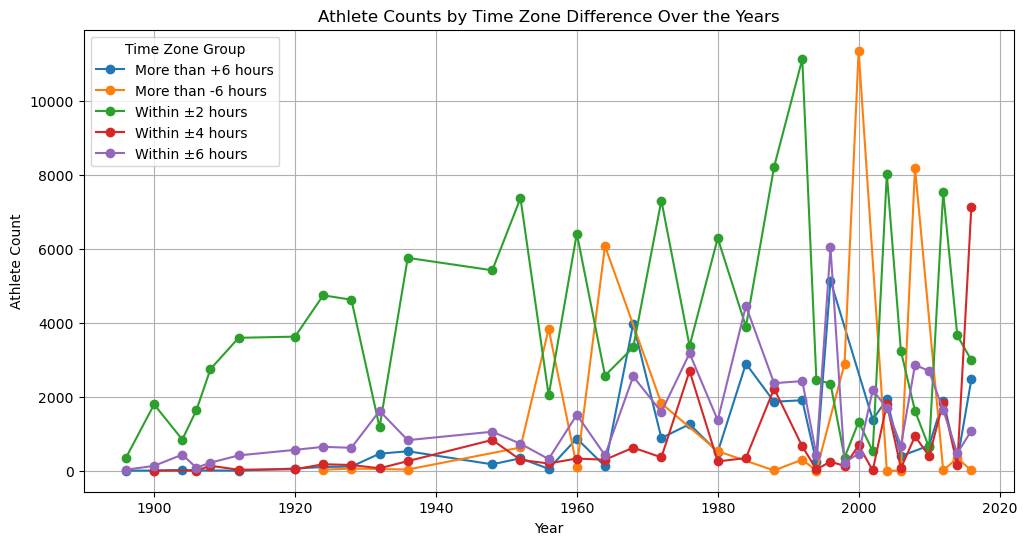

In [85]:
def plot_grouped_data(grouped_data):
    plt.figure(figsize=(12, 6))
    for group, data in grouped_data.groupby('Time_Zone_Group'):
        plt.plot(data['Year'], data['Athlete_Count'], marker='o', label=group)

    plt.title('Athlete Counts by Time Zone Difference Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Athlete Count')
    plt.legend(title='Time Zone Group')
    plt.grid(True)
    plt.show()

plot_grouped_data(grouped_data)

### 1.4. Does having a higher GDP per capita have any significant impact on athlete representation?

Read the two datasets: `athlete_events`, containing Olympic athlete and event information, and `gdp_data`, which includes GDP data. In the gdp_data file we skip the first four rows (extra headers).

In [88]:
data_path = 'athlete_events.csv'
gdp_data_path = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_76.csv'

athlete_events = pd.read_csv(data_path)
gdp_data = pd.read_csv(gdp_data_path, skiprows=4)


We transform the gdp_data DataFrame into a long format using the melt function, where each row represents a specific country, year, and GDP per capita. The column `Country Name` is renamed to `Country`, and the `Year` column is converted to a numeric data type, with invalid entries coerced to NaN. Rows with missing values in the `Year` or `GDP_Per_Capita` columns are then removed.

In [90]:
gdp_long = gdp_data.melt(id_vars=['Country Name'], var_name='Year', value_name='GDP_Per_Capita')
gdp_long = gdp_long.rename(columns={'Country Name': 'Country'})
gdp_long['Year'] = pd.to_numeric(gdp_long['Year'], errors='coerce')
gdp_long = gdp_long.dropna(subset=['Year', 'GDP_Per_Capita'])

We convert the Year column in athlete_events to numeric and merge it with gdp_long using a left join, matching Team and Year with Country and Year to add GDP data.

In [92]:
athlete_events['Year'] = pd.to_numeric(athlete_events['Year'], errors='coerce')
athlete_events = athlete_events.merge(gdp_long, left_on=['Team', 'Year'], right_on=['Country', 'Year'], how='left')
athlete_events.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,GDP_Per_Capita
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,366.460692
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,6300.58218
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,17770.616238


This function, `categorize_gdp`, classifies GDP per capita into four categories:

- **Rich**: GDP ≥ 25,000  
- **Moderate**: 10,000 ≤ GDP < 25,000  
- **Poor**: 5,000 ≤ GDP < 10,000  
- **Very Poor**: GDP < 5,000  

In [94]:
def categorize_gdp(gdp):
    if gdp >= 25000:
        return 'Rich'
    elif 10000 <= gdp < 25000:
        return 'Moderate'
    elif 5000 <= gdp < 10000:
        return 'Poor'
    else:
        return 'Very Poor'

Categorize country's GDP in `athlete_events` into `GDP_Category` and groups the data by `Year` and `GDP_Category`, counting athletes in each group. The results are stored in `representation_over_time` with athlete counts.

In [96]:
athlete_events['GDP_Category'] = athlete_events['GDP_Per_Capita'].apply(categorize_gdp)
representation_over_time = athlete_events.groupby(['Year', 'GDP_Category'])['ID'].count().reset_index(name='Athlete_Count')

We make a visualization to asses our results.

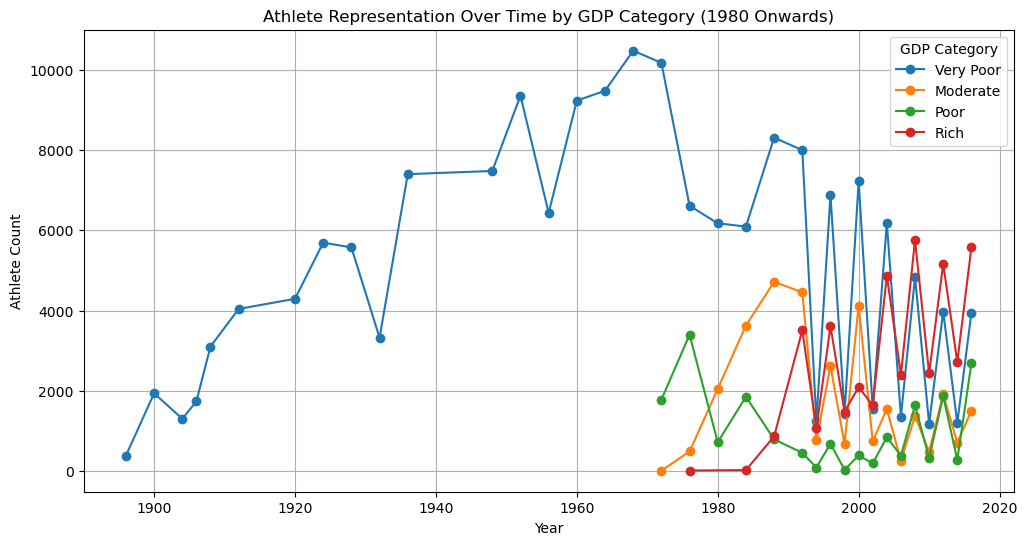

In [98]:
def plot_representation_over_time(data):
    plt.figure(figsize=(12, 6))
    for category in data['GDP_Category'].unique():
        category_data = data[data['GDP_Category'] == category]
        plt.plot(category_data['Year'], category_data['Athlete_Count'], marker='o', label=category)
    
    plt.title('Athlete Representation Over Time by GDP Category (1980 Onwards)')
    plt.xlabel('Year')
    plt.ylabel('Athlete Count')
    plt.legend(title='GDP Category')
    plt.grid(True)
    plt.show()

plot_representation_over_time(representation_over_time)